In [1]:
# https://zhuanlan.zhihu.com/p/427008381
import numpy as np
import pandas as pd
import mitosheet ## 数据查看
import sviewgui.sview as sv ## 查看数据
import missingno  ## 缺失数据查看
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline ## 管道
from sklearn.decomposition import PCA ## 主成分分析，降维
from sklearn.impute import SimpleImputer, KNNImputer ## 分类器
from sklearn.compose import ColumnTransformer ## 数据处理
from sklearn.preprocessing import RobustScaler, OneHotEncoder ## 数据预处理
from sklearn.ensemble import RandomForestClassifier ## 随机森林
from sklearn.model_selection import cross_val_score, RandomizedSearchCV ## 模型验证，调参

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'png' ## 设置画图图片格式

In [2]:
# 获取数据
titanic = pd.read_csv('/home/wtian/play_ground/ML/datasets/titanic/train.csv')

In [3]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# 查看数据集基本特征
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# 查看数据是否有缺失
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

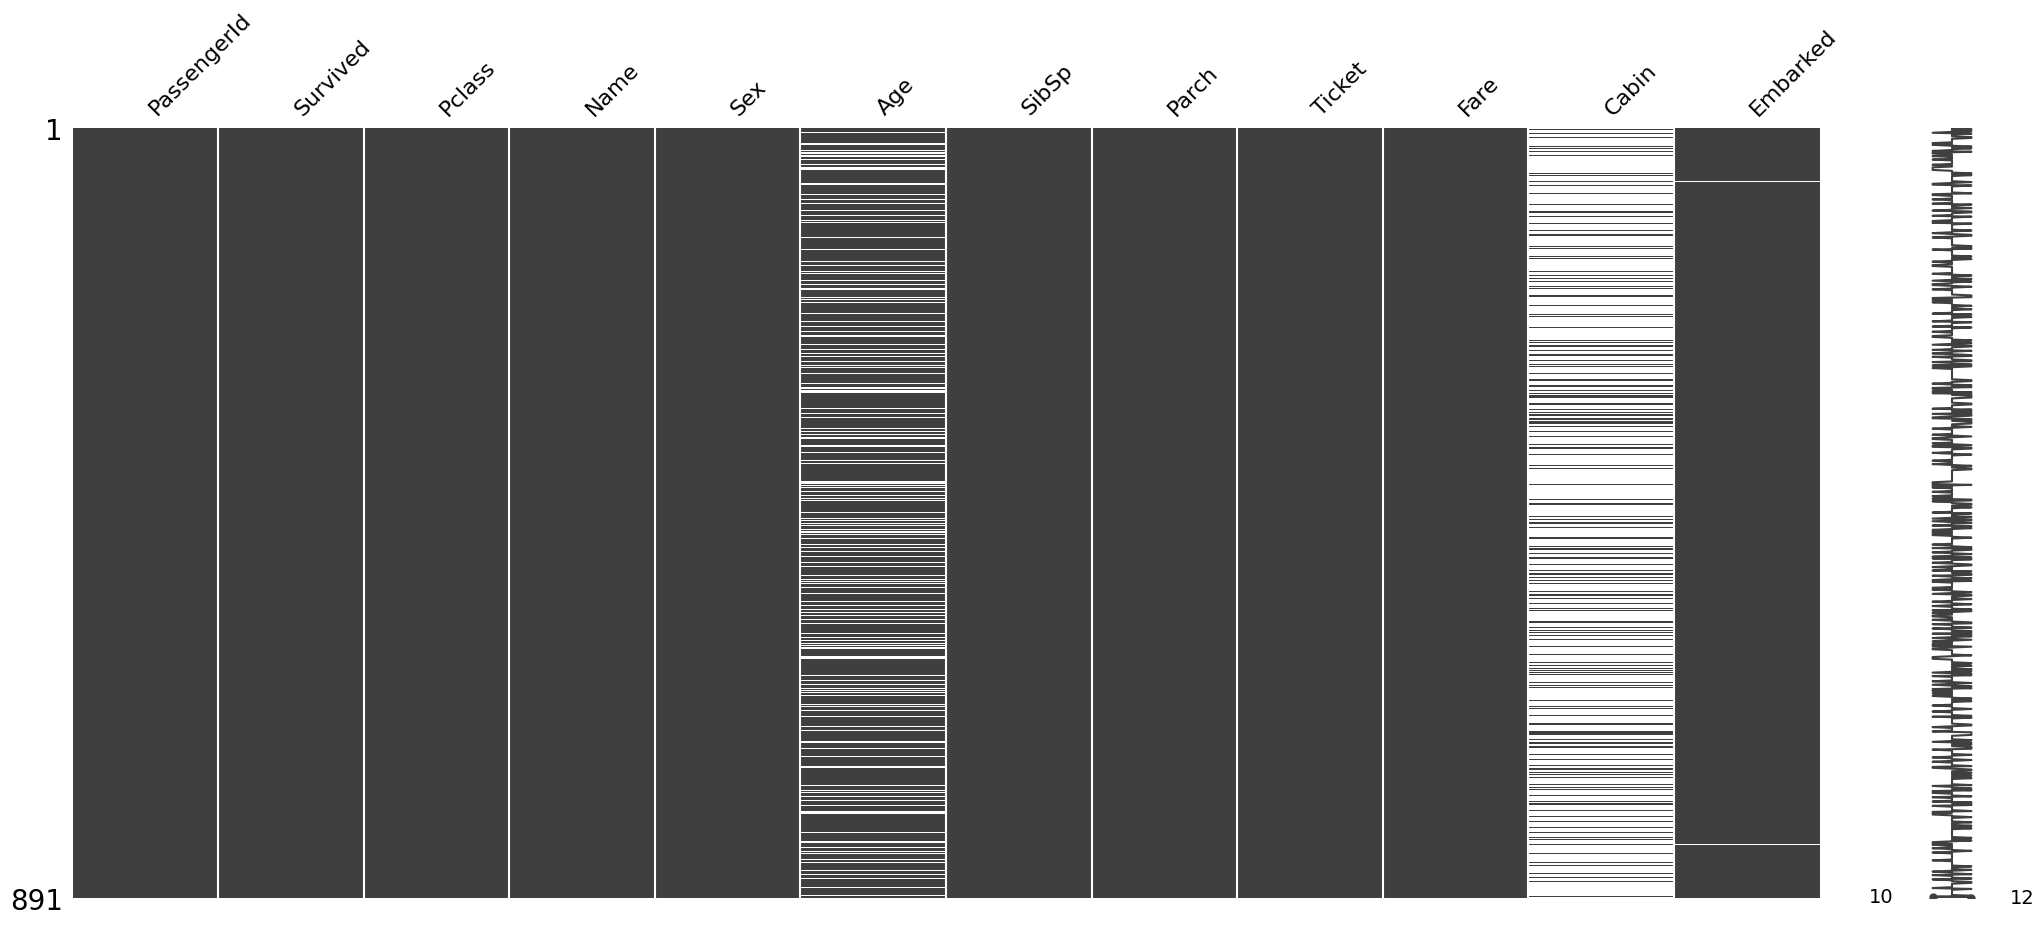

In [7]:
missingno.matrix(titanic) ## 查看数据缺失的大致分布
plt.show()

In [8]:
# 删除缺失过多的 carbin 变量
titanic.drop('Cabin', axis=1,inplace=True)

In [9]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

# 特征合并

<Axes: >

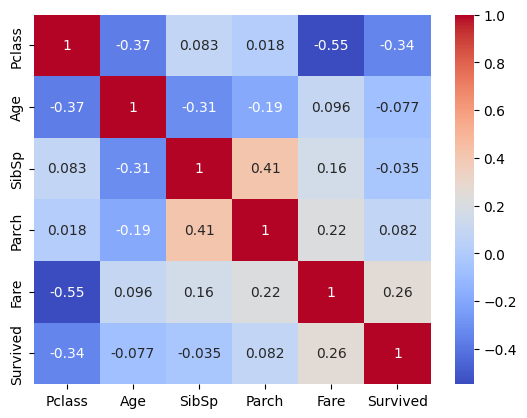

In [10]:
corrhm = sns.heatmap(titanic[['Pclass','Age','SibSp','Parch','Fare','Survived']].corr(),
                annot=True, cmap = "coolwarm")
corrhm

可以看到，sibsp和parch两个变量相关程度极高。

对于相关性高的变量，我们可以考虑将两者合并为一个变量。

sibsp：兄妹的数量；parch：父母和子女的数量；

可以考虑将两者合并为 family_size 变量，衡量家人数量的多少。这里只需要将两者直接相加即可，同时生成一个是否为“孤家寡人 is_alone”变量。

In [11]:
titanic['family_size'] = titanic['SibSp'] + titanic['Parch']
titanic.drop(['SibSp','Parch'],axis=1,inplace=True)
titanic['is_alone'] = 1
titanic.loc[titanic['family_size'] > 1, 'is_alone'] = 0

In [12]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,family_size,is_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,211536,13.0000,S,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,112053,30.0000,S,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,W./C. 6607,23.4500,S,3,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,111369,30.0000,C,0,1


# 构建特征

In [13]:
# 构造 title 变量
titanic['title'] = titanic['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,family_size,is_alone,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,1,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,0,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,1,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,0,1,Mr


In [14]:
titanic.title.value_counts().to_frame()

,count
title,
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Col,2
Mlle,2
Major,2


In [15]:
pd.crosstab(titanic['title'],titanic['Sex'])

Sex,female,male
title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [16]:
## Mrs 生存的比例
print(f"Mrs: {np.sum(titanic['Survived'].astype(int)[titanic.title == 'Mrs']) / len(titanic.title == 'Mrs')}")
##  Miss 生存的比例
print(f"Miss: {np.sum(titanic['Survived'].astype(int)[titanic.title == 'Miss']) / len(titanic.title == 'Miss')}")

Mrs: 0.1111111111111111
Miss: 0.1425364758698092


可见，两者的生存比例差别不大，可以考虑合并。Title 的称呼分类过于复杂，因此需要简化。

In [17]:
rare_titles = (titanic['title'].value_counts() < 10)
rare_titles

title
Mr              False
Miss            False
Mrs             False
Master          False
Dr               True
Rev              True
Col              True
Mlle             True
Major            True
Ms               True
Mme              True
Don              True
Lady             True
Sir              True
Capt             True
the Countess     True
Jonkheer         True
Name: count, dtype: bool

In [18]:
titanic.title.loc[titanic.title == 'Miss'] = 'Mrs'
titanic['title'] = titanic.title.apply(lambda x:'rare' if rare_titles[x] else x)
titanic

/tmp/ipykernel_3584973/2255487103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic.title.loc[titanic.title == 'Miss'] = 'Mrs'


,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,family_size,is_alone,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,1,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,0,1,Mrs
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,1,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,0,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,211536,13.0000,S,0,1,rare
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,112053,30.0000,S,0,1,Mrs
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,W./C. 6607,23.4500,S,3,0,Mrs
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,111369,30.0000,C,0,1,Mr


In [19]:
titanic.title.value_counts().to_frame() ## 最终title剩下四大类

,count
title,
Mr,517
Mrs,307
Master,40
rare,27


# 基于管道的数据处理

## 分类变量

In [21]:
cat_cols = ['Embarked', 'Sex', 'Pclass', 'title', 'is_alone']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), ## 最高频数值插补
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)), ## 分类变量的0-1编码（转化为哑变量）
    ('pca', PCA(n_components=10)) ## 主成分分析用于哑变量数据的降维
])

这段Python代码定义了一个名为`cat_transformer`的管道（Pipeline）对象，用于对分类变量进行处理。分类变量通常包括离散的、非数值型的数据，如性别（male或female）、登船港口（C、Q、S）、船舱等级（1、2、3等）等。这段代码的具体实现原理如下：

1. 使用`SimpleImputer`对缺失值进行插补，默认为使用“最多频率”填充。
2. 使用`OneHotEncoder`对分类变量进行0-1编码，即一个变量可能有多个取值，转化为多个独立的特征（哑变量）。
3. 使用`PCA`对降维后的数据进行主成分分析，提取前10个主成分，从而降低数据的维度。

以下是对这些步骤的详细解释：

1. `SimpleImputer`：缺失值处理组件，用于填充缺失值。这里使用“最多频率”填充策略，即在连续变量中，选择出现次数最多的值填充缺失值；在分类变量中，选择出现次数最多的值。
2. `OneHotEncoder`：0-1编码组件，用于将分类变量转换为哑变量。这样，每个分类变量都可以被表示为一个具有0或1值的向量，从而便于在模型中进行处理。
3. `PCA`：主成分分析组件，用于降维。主成分分析是一种常用的数据降维方法，通过计算矩阵的主列来减少数据的维度。这里设置为保留前10个主成分，从而降低数据的维度。

需要注意的是，这段代码仅适用于分类变量处理，对于连续变量，如年龄、船费等，应该直接使用数值型数据，而不需要进行上述编码处理。


## 数值变量

In [22]:
num_cols = ['Age', 'Fare', 'family_size']
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

这段Python代码定义了一个名为`num_transformer`的管道（Pipeline）对象，用于对包含在`num_cols`列表中的数值型数据进行转换。实现原理如下：

1. 使用`KNNImputer`对缺失的数值型数据进行填充。`KNNImputer`是一个基于k-近邻算法的缺失值填充器，它通过计算每个缺失值点周围的k个最近邻点的均值来填充缺失值。这里的`n_neighbors`参数设置为5。

2. 对填充后的数据进行缩放。这里使用`RobustScaler`对数据进行缩放，使其更好地反映线性关系。

RobustScaler 是 scikit-learn 库中的一种数据缩放器，它能够处理异常值和离群点。它通过以下步骤对输入数据进行缩放：

1. 计算数据的均值和标准差。
2. 使用均值和标准差对数据进行标准化。
3. 根据指定的 quantile_range（阈值范围）来处理异常值和离群点。默认情况下，阈值范围为 (0.25, 0.75)。
4. 根据处理后的数据计算新的均值和标准差。
5. 使用新的均值和标准差对数据进行缩放。

RobustScaler 可以使用 fit_transform() 方法来对数据进行拟合和转换，或者使用 fit() 和 transform() 方法分别进行拟合和转换。

使用 RobustScaler 的场景：

- 当数据包含异常值或离群点时，使用 RobustScaler 可以保持数据的线性关系。
- 当需要对不同分布的数据进行比较时，使用 RobustScaler 可以确保数据的相似性。
- 当需要对非线性数据进行缩放时，RobustScaler 可以保持数据的线性关系。

注意：在使用 RobustScaler 之前，需要先导入 scikit-learn 库。

示例：

```python
from sklearn.preprocessing import RobustScaler

# 生成一些随机数据
data = [[-3, 0, 3], [6, 3, 0], [3, 6, 9], [-8, 4, 3], [0, 2, 6]]

# 创建 RobustScaler 对象
scaler = RobustScaler()

# 对数据进行拟合和转换
transformed_data = scaler.fit_transform(data)

# 或者使用 fit() 和 transform() 方法
# scaler.fit(data)
# transformed_data = scaler.transform(data)

print(transformed_data)
```

输出：

```
[[ 0.  0.  0.]
 [ 3.  1.  0.]
 [ 1.  3.  1.]
 [-1.  0.  0.]
 [ 0.  1.  2.]]
```

在这个例子中，我们首先导入了 RobustScaler，然后生成了一些随机数据。接下来，我们创建了一个 RobustScaler 对象，并使用 fit_transform() 方法对数据进行了拟合和转换。最后，我们打印了转换后的数据。


In [23]:
# 数据预处理总管道
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Random Forest 随机森林建模

In [24]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [25]:
# 筛选特征值和目标值
x = titanic[['Pclass','Age','Sex','Fare','Embarked','family_size','is_alone','title']]
y = titanic['Survived']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [27]:
#  evaluate the performance of our model
cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7893627499261303

# 超参寻优

In [28]:
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 15))}

random_forest_dist = {'classifier__n_estimators': list(range(50, 500)),
                      'classifier__max_depth': list(range(2, 20)),
                      'classifier__bootstrap': [True, False]}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **random_forest_dist}

random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   n_iter=100)

这段代码是用于在训练一个机器学习模型时，通过随机搜索来寻找最优参数。具体来说，它使用了`RandomizedSearchCV`类来自动化地搜索最优的参数组合，以提高模型的性能。

1. 首先，定义了三个参数分布，分别用于数字特征（numeric features）的处理、类别特征的处理和随机森林模型的参数。这些参数分布包括要搜索的参数的值的范围，例如`list(range(2, 15))`表示要搜索2到14之间的整数。

2. 接下来，将这些参数分布合并成一个总的参数分布，命名为`param_dist`。这个合并的过程是将字典`num_transformer_dist`、`cat_transformer_dist`和`random_forest_dist`的键值对依次添加到空字典`param_dist`中。

3. 然后，使用`RandomizedSearchCV`类创建一个随机搜索对象`random_search`。这个对象会根据给定的参数分布和迭代次数，自动搜索最优的参数组合。

创建`random_search`对象时，需要传入以下参数：

- `estimator`：要搜索最优参数的模型。在这个例子中，我们使用了一个随机森林分类器（`RandomForestClassifier`）。
- `param_distributions`：要搜索的参数的分布。这个参数是一个字典，键是参数的名称，值是参数的分布。
- `n_iter`：搜索的迭代次数。越高，搜索的越全面，但会增加运行时间。

注意：在实际使用中，还需要导入相关的库和模块，例如`from sklearn.ensemble import RandomForestClassifier`。

In [29]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Age',
                                                                                'Fare',
                                                                                'family_size']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('pca'...
                                                                     74, 75, 76,
                                                                     77, 78, 79, ...],
                                        'preprocessor__cat__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__cat__pca__n_components': [2,
                                                                                 3,
                                                                                 4,
                                                                                 5,
                                                                                 6,
                                                                                 7,
                                                                                 8,
                                                                                 9,
                                                                                 10,
                                                                                 11,
                                                                                 12,
                                                                                 13,
                                                                                 14],
                                        'preprocessor__num__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__num__imputer__n_neighbors': [2,
                                                                                    3,
                                                                                    4,
                                                                                    5,
                                                                                    6,
                                                                  

In [30]:
# 模型优化结果
random_search.best_score_

0.8258051807347583

In [31]:
random_search.best_params_

{'preprocessor__num__imputer__n_neighbors': 13,
 'preprocessor__num__imputer__add_indicator': False,
 'preprocessor__cat__pca__n_components': 8,
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__cat__imputer__add_indicator': True,
 'classifier__n_estimators': 219,
 'classifier__max_depth': 4,
 'classifier__bootstrap': True}

In [32]:
# 评估
y_pred = random_search.predict(X_test) ## 预测
#y_pred[0:6] ## 查看前6个

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       114
           1       0.85      0.72      0.78        65

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



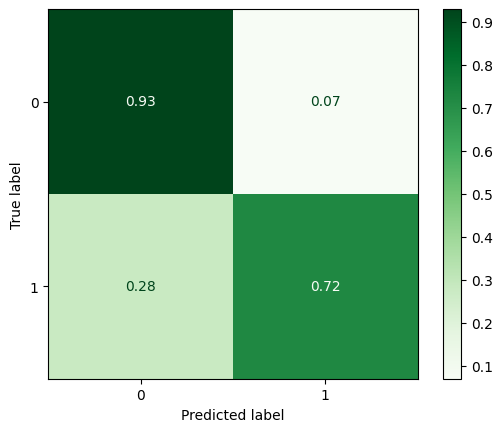

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(random_search, X_test, y_test, cmap=plt.cm.Greens, normalize='true')
plt.show() ## 混淆矩阵